In [1]:
import torch as pt
import torchvision
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from torchvision import transforms

C:\Users\pwrxn\miniconda3\envs\pytorch\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1. Getting data

In [2]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool=True) -> Path:
    '''Downloads the dataset from identified destination'''
    # Setup path to datafolder
    data_path = Path('data/')
    image_path = data_path / destination

    # if image folder doesn't exist, create it
    if image_path.is_dir():
        print(f'[INFO] {image_path} directory already exists, skipping download.')
    else:
        print(f'[INFO] Did not find {image_path} directory, creating one...')
        image_path.mkdir(parents=True, exist_ok=True)

        # Download the target data
        target_file = Path(source).name
        with open(data_path / target_file, 'wb') as f:
            request = requests.get(source)
            print(f'[INFO] Downloading {target_file} from {source}...')
            f.write(request.content)

        # Unzip target file
        with zipfile.ZipFile(data_path / target_file, 'r') as zip_ref:
            print(f'[INFO] Unzipping {target_file} data...')
            zip_ref.extractall(image_path)

        # Remove zip file if needed
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

In [3]:
image_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                           destination='pizza_steak_sushi')

image_path

[INFO] data\pizza_steak_sushi directory already exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
# setup directories 
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [5]:
# Setup ImageNet normalization levels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])
print(f'Manually created transforms: {manual_transforms}')

# Create Dataloaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x270a2aa4e50>,
 ['pizza', 'steak', 'sushi'])

## Create Dataloaders using automatic transforms

In [6]:
# Setup pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights 
automatic_transforms = weights.transforms()

# Create Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=automatic_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x270b1023f10>,
 ['pizza', 'steak', 'sushi'])

## Gettin a pretrained model


In [7]:
model = torchvision.models.efficientnet_b0(weights=weights)

In [8]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Freeze all base layers by setting their requires_grad attribute to False

In [9]:
for param in model.features.parameters():
    param.requires_grad = False

In [10]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [11]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
# Adjust the classifier head
pt.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names)))

In [13]:
from torchinfo import summary

summary(model,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train a single model and track results

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = pt.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [16]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step

def train(model: pt.nn.Module, 
          train_dataloader: pt.utils.data.DataLoader, 
          test_dataloader: pt.utils.data.DataLoader, 
          optimizer: pt.optim.Optimizer,
          loss_fn: pt.nn.Module,
          epochs: int,
          device: pt.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ###New: Experiment tracking ###
        writer.add_scalars(main_tag='Loss',
                           tag_scalar_dict={'train_loss': train_loss,
                                            'test_loss': test_loss},
                           global_step=epoch)
        writer.add_scalars(main_tag='Accuracy',
                           tag_scalar_dict={'train_acc': train_acc,
                                            'test_acc': test_acc},
                           global_step=epoch)

        writer.add_graph(model=model,
                         input_to_model=pt.randn(32,3,224,224))

    writer.close()
    # Return the filled results at the end of the epochs
    return results

In [17]:
pt.manual_seed(42)

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=None)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0977 | train_acc: 0.3828 | test_loss: 0.8856 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9197 | train_acc: 0.6406 | test_loss: 0.8150 | test_acc: 0.7850
Epoch: 3 | train_loss: 0.7611 | train_acc: 0.8672 | test_loss: 0.6581 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6884 | train_acc: 0.7695 | test_loss: 0.6214 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6468 | train_acc: 0.7969 | test_loss: 0.6053 | test_acc: 0.8665


## View our model's results with TensorBoard

In [18]:
# Let's view our experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 23124), started 4 days, 20:31:35 ago. (Use '!kill 23124' to kill it.)

## Create a function to prepare a `SummaryWriter()` instance

In [22]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra:
                  str = None):
    from datetime import datetime
    import os

    # get timestamp of current date in reverse order
    timestamp = datetime.now().strftime('%Y-%m-%d')

    if extra:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
    print(f'[INFO] Created SummaryWriter saving to {log_dir}')
    return SummaryWriter(log_dir=log_dir)

In [24]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step

def train(model: pt.nn.Module, 
          train_dataloader: pt.utils.data.DataLoader, 
          test_dataloader: pt.utils.data.DataLoader, 
          optimizer: pt.optim.Optimizer,
          loss_fn: pt.nn.Module,
          epochs: int,
          device: pt.device,
          writer: pt.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ###New: Experiment tracking ###
        if writer:
        
            writer.add_scalars(main_tag='Loss',
                               tag_scalar_dict={'train_loss': train_loss,
                                                'test_loss': test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag='Accuracy',
                               tag_scalar_dict={'train_acc': train_acc,
                                                'test_acc': test_acc},
                               global_step=epoch)
    
            writer.add_graph(model=model,
                             input_to_model=pt.randn(32,3,224,224))

            writer.close()
        else:
            pass
    # Return the filled results at the end of the epochs
    return results

## Setting up a series of modeling experiments

In [25]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination='pizza_steak_sushi')

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination='pizza_steak_sushi_20_percent')

[INFO] data\pizza_steak_sushi directory already exists, skipping download.
[INFO] Did not find data\pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [27]:
train_dir_10_percent = data_10_percent_path / 'train'
train_dir_20_percent = data_20_percent_path / 'train'

# Setup the test directory
test_dir = data_10_percent_path / 'test'

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [28]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [30]:
BATCH_SIZE = 32

# create 10% training and test dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transforms,
                                                                                          batch_size=BATCH_SIZE)

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transforms,
                                                                                          batch_size=BATCH_SIZE)
print(f'Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}')
print(f'Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}')
print(f'Number of batches of size {BATCH_SIZE} in 10% train data: {len(test_dataloader)}')
print(f'Class names: {class_names}')

Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15
Number of batches of size 32 in 10% train data: 3
Class names: ['pizza', 'steak', 'sushi']


## Create feature extractor models

In [31]:
# Create an EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\pwrxn/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|█████████████████████████████████████████████████████████████████████████████| 35.2M/35.2M [00:07<00:00, 4.79MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [32]:
summary(model=effnetb2,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [41]:
OUT_FEATURES = len(class_names)

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights)

    for param in model.features.parameters():
        param.requires_grad = False

    pt.manual_seed(42)
    model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    )
    model.name = 'effnetb0'
    print(f'[INFO] Created new {model.name} model...')
    return model

def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.features.parameters():
        param.requires_grad = False

    pt.manual_seed(42)
    model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    )
    model.name = 'effnetb2'
    print(f'[INFO] Created new {model.name} model...')
    return model

In [44]:
created_model_test_effnetb2 = create_effnetb2()
created_model_test_effnetb0 = create_effnetb0()

[INFO] Created new effnetb2 model...
[INFO] Created new effnetb0 model...


In [43]:
summary(model=created_model_test,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Create experiments and set up a training code

In [48]:
num_epochs = [5, 10]

# Create models list (need to creaet a new model for each experiment)
models = ['effnetb0', 'effnetb2']

# Create a Dataloaders dictionary
train_dataloaders = {'data_10_percent': train_dataloader_10_percent,
                     'data_20_percent': train_dataloader_20_percent}

In [51]:
%%time 
from going_modular.utils import save_model

pt.manual_seed(42)

experiment_number = 0

# Loop through each Dataloader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through epochs
    for epochs in num_epochs:
        # Loop through each model name and create a new model instance
        for model_name in models:

            # Print out info
            experiment_number += 1
            print(f'[INFO] Experiment number: {experiment_number}')
            print(f'[INFO] Model: {model_name}')
            print(f'[INFO] Dataloader: {dataloader_name}')
            print(f'[INFO] Numver of epochs: {epochs}')

            # Select and create the model
            if model_name == 'effnetb0':
                model = create_effnetb0()
            else:
                model = create_effnetb2()

        loss_fn = nn.CrossEntropyLoss()
        optimizer = pt.optim.Adam(params=model.parameters(), lr=0.001)

        # Train target model with target dataloader and track experiments
        train(model=model,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=epochs,
              device='cpu',
              writer=create_writer(experiment_name=dataloader_name,
                                   model_name=model_name,
                                   extra=f'{epochs}_epochs'))
        # Save model to the file
        save_filepath = f'{model_name}_{dataloader_name}_{epochs}_epochs.pth'
        save_model(model=model,
                   target_dir='models',
                   model_name=save_filepath)
        print('-'*50 + '\n')

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] Dataloader: data_10_percent
[INFO] Numver of epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] Dataloader: data_10_percent
[INFO] Numver of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2024-03-02\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0891 | train_acc: 0.3398 | test_loss: 0.9470 | test_acc: 0.7102
Epoch: 2 | train_loss: 0.9269 | train_acc: 0.6523 | test_loss: 0.8774 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.8390 | train_acc: 0.7070 | test_loss: 0.7530 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7206 | train_acc: 0.7344 | test_loss: 0.7185 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.6544 | train_acc: 0.8125 | test_loss: 0.7206 | test_acc: 0.8769
[INFO] Saving model to: models\effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] Dataloader: data_10_percent
[INFO] Numver of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] Dataloader: data_10_percent
[INFO] Numver of epochs: 10
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2024-03-02\data_10_percent\effnetb2\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0891 | train_acc: 0.3398 | test_loss: 0.9470 | test_acc: 0.7102
Epoch: 2 | train_loss: 0.9269 | train_acc: 0.6523 | test_loss: 0.8774 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.8390 | train_acc: 0.7070 | test_loss: 0.7530 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7206 | train_acc: 0.7344 | test_loss: 0.7185 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.6544 | train_acc: 0.8125 | test_loss: 0.7206 | test_acc: 0.8769
Epoch: 6 | train_loss: 0.6021 | train_acc: 0.7969 | test_loss: 0.6902 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.5785 | train_acc: 0.8047 | test_loss: 0.6362 | test_acc: 0.8466
Epoch: 8 | train_loss: 0.5145 | train_acc: 0.9375 | test_loss: 0.5894 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5291 | train_acc: 0.8008 | test_loss: 0.5756 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.5212 | train_acc: 0.8164 | test_loss: 0.5746 | test_acc: 0.8873
[INFO] Saving model to: models\effnetb2_data_10_percent_10_epochs.pth
---------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9881 | train_acc: 0.5167 | test_loss: 0.7968 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7439 | train_acc: 0.7917 | test_loss: 0.6647 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.6461 | train_acc: 0.8125 | test_loss: 0.5793 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5434 | train_acc: 0.8396 | test_loss: 0.5449 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4623 | train_acc: 0.8812 | test_loss: 0.4805 | test_acc: 0.9384
[INFO] Saving model to: models\effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] Dataloader: data_20_percent
[INFO] Numver of epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] Dataloader: data_20_percent
[INFO] Numver of epochs: 10
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs\2024-03-02\data_20_percent\effnetb2\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9881 | train_acc: 0.5167 | test_loss: 0.7968 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7439 | train_acc: 0.7917 | test_loss: 0.6647 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.6461 | train_acc: 0.8125 | test_loss: 0.5793 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.5434 | train_acc: 0.8396 | test_loss: 0.5449 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4623 | train_acc: 0.8812 | test_loss: 0.4805 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.4241 | train_acc: 0.8792 | test_loss: 0.4413 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.3609 | train_acc: 0.9271 | test_loss: 0.4456 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.3950 | train_acc: 0.8896 | test_loss: 0.4221 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.4103 | train_acc: 0.8604 | test_loss: 0.4049 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3831 | train_acc: 0.8667 | test_loss: 0.4290 | test_acc: 0.8977
[INFO] Saving model to: models\effnetb2_data_20_percent_10_epochs.pth
---------------------------------------

## View experiments in TensorBoard

In [52]:
# Let's view our experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 23124), started 4 days, 23:05:40 ago. (Use '!kill 23124' to kill it.)

In [ ]:
# !tensorboard dev upload --logdir runs \
#     --name 'PyTorch Experiment tracking: Foodvision mini model'
#     --description 'Comparing results of different model size, training data and training time'

## Load the best model and make predictions with it

In [53]:
# Setup best model filepath
best_model_path = 'models/effnetb2_data_20_percent_5_epochs.pth'

# Initiate a new instance of EffNetB2 (to load in the saved state_dict())
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(pt.load(best_model_path))

[INFO] Created new effnetb2 model...


<All keys matched successfully>

In [54]:
from pathlib import Path

effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f'EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB')

EfficientNetB2 feature extractor model size: 29 MB


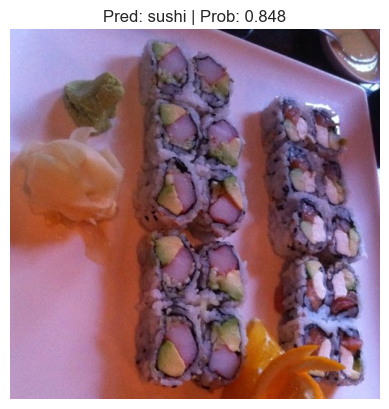

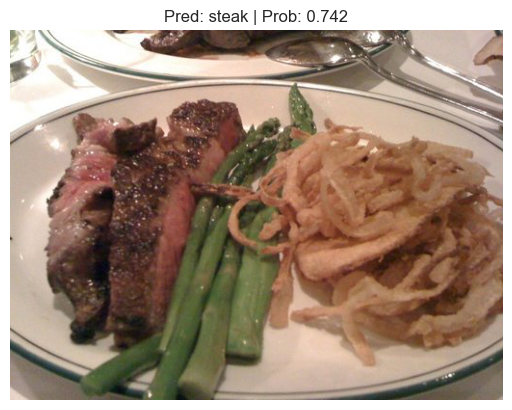

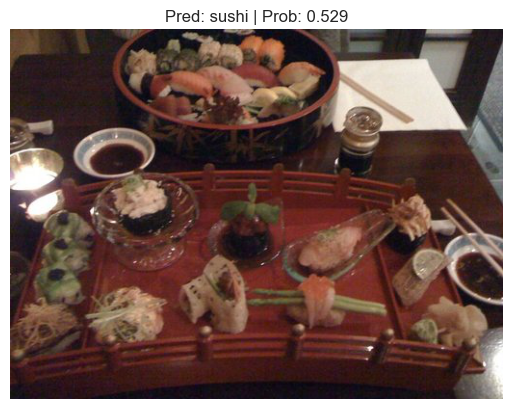

In [55]:
from going_modular.predictions import pred_and_plot_image

# Get random list of 3 image path namesa and test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / 'test').glob('*/*.jpg'))
test_image_path_sample = random.sample(test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))